# Style Transfer

An example below is inspired [by original tutorial on TensorFlow](https://www.tensorflow.org/tutorials/generative/style_transfer), as well as [by this blog post](https://medium.com/mlreview/making-ai-art-with-style-transfer-using-keras-8bb5fa44b216). Another good example of Style Transfer using CNTK framework is [here](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_205_Artistic_Style_Transfer.ipynb). Here is an original paper on [Artistic Style Transfer](https://arxiv.org/abs/1508.06576).

Main ideas behind style transfer are the following:

* Starting from white noise, we try to optimize the current image $x$ to minimize some loss function
* Loss function consists of three components $\mathcal{L(x)} = \alpha\mathcal{L}_c(x,i) + \beta\mathcal{L}_s(x,s)+\gamma\mathcal{L}_t(x)$
   - $\mathcal{L}_c$ - content loss - shows how close the current image $x$ is to original image $i$
   - $\mathcal{L}_s$ - style loss - shows how close the current image $x$ is to style image $s$
   - $\mathcal{L}_t$ - total variation loss (we will not consider it in our example) - makes sure that the resulting image is smooth, i.e. it shows the mean squared error of neighbouring pixels of the image $x$
   
Those loss functions have to be designed in a clever way, so that for example style loss corresponds to styles of the images being similar, and not the actual content. For that, we will compare some deeper feature layers of a CNN which looks at the image.

Let's start by loading a couple of images:

In [1]:
!mkdir -p images
!curl https://cdn.pixabay.com/photo/2016/05/18/00/27/franz-marc-1399594_960_720.jpg > images/style.jpg
!curl https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Golden_tabby_and_white_kitten_n01.jpg/1280px-Golden_tabby_and_white_kitten_n01.jpg > images/image.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  210k  100  210k    0     0  2670k      0 --:--:-- --:--:-- --:--:-- 2670k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  131k  100  131k    0     0   459k      0 --:--:-- --:--:-- --:--:--  459k


In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
import IPython.display as display

Let's load those images and resize them to $512\times512$. Also, we will generate resulting image `img_result` as a random array.

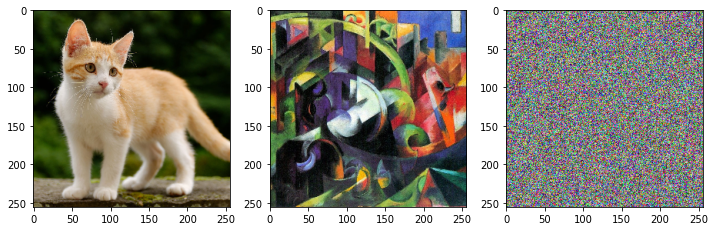

In [31]:
img_size = 256

def load_image(fn):
  x = cv2.imread(fn)
  return cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

img_style = load_image('images/style.jpg')
img_content = load_image('images/image.jpg')
img_content = img_content[:,200:200+857,:]
img_content = cv2.resize(img_content,(img_size,img_size))
img_style = img_style[:,200:200+671,:]
img_style = cv2.resize(img_style,(img_size,img_size))

img_result = np.random.uniform(size=(img_size,img_size,3))

matplotlib.rcParams['figure.figsize'] = (12, 12)
matplotlib.rcParams['axes.grid'] = False

fig,ax = plt.subplots(1,3)
ax[0].imshow(img_content)
ax[1].imshow(img_style)
ax[2].imshow((255*img_result).astype(int))
plt.show()

To calculate style loss and content loss, we need to work in the feature space extracted by a CNN. We can use different CNN architectures, but for simplicity in our case we will chose VGG-19, pre-trained on *ImageNet*.

In [32]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
vgg.trainable = False

Let's have a look at the model architecture:

In [33]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Let's define a function that will allow us to extract intermediate features from VGG network: 

In [34]:
def layer_extractor(layers):
    outputs = [vgg.get_layer(x).output for x in layers]
    model = tf.keras.Model([vgg.input],outputs)
    return model 

## Content Loss

**Content loss** will show how close our current image $x$ is to the original image. It looks at the intermediate feature layers in CNN, and computes square error. Content loss on layer $l$ will be defined as
$$
\mathcal{L}_c = {1\over2}\sum_{i,j} (F_{ij}^{(l)}-P_{ij}^{(l)})^2
$$
where $F^{(l)}$ and $P^{(l)}$ -- features at layer $l$.

In [35]:
content_layers = ['block4_conv2'] 
content_extractor = layer_extractor(content_layers)

content_target = content_extractor(preprocess_input(tf.expand_dims(img_content,axis=0)))

def content_loss(img):
    z = content_extractor(preprocess_input(tf.expand_dims(255*img,axis=0))) 
    return 0.5*tf.reduce_sum((z-content_target)**2)

Now we will implement the main trick of style transfer - **optimization**. We will start with random image, and then use TensorFlow optimizer to adjust this image to minimize content loss.

**Important**: in our case, all computations are performed using GPU-aware *TensorFlow* framework, which allows this code to run much more efficiently on GPU.

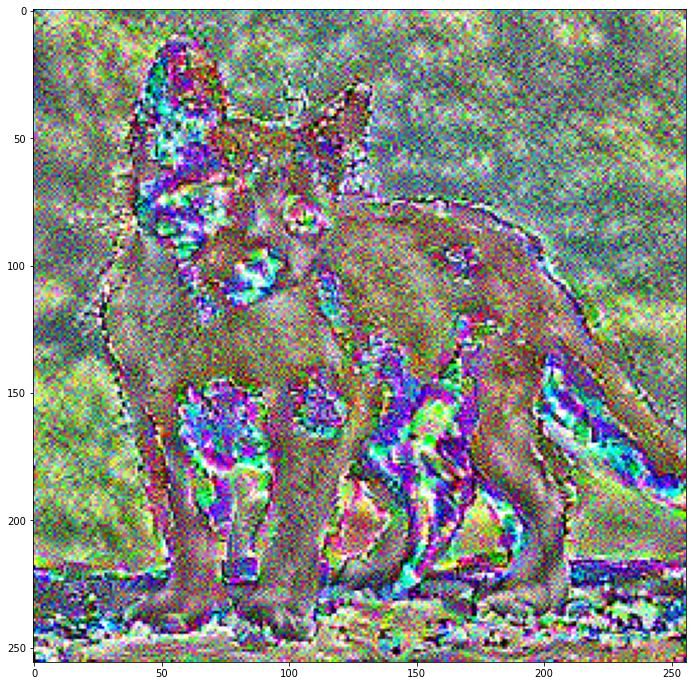

In [63]:
img = tf.Variable(img_result)
opt = tf.optimizers.Adam(learning_rate=0.002, beta_1=0.99, epsilon=1e-1)

clip = lambda x : tf.clip_by_value(x,clip_value_min=0,clip_value_max=1)

def optimize(img,loss_fn):
    with tf.GradientTape() as tape:
        loss = loss_fn(img)
    grad = tape.gradient(loss,img)
    opt.apply_gradients([(grad,img)])
    #img.assign(tf.clip_by_value(img,clip_value_min=0,clip_value_max=1))

def train(img,loss_fn,epochs=10,steps_per_epoch=100):
    for _ in range(epochs):
        display.clear_output(wait=True)
        plt.imshow((255*clip(img)).numpy().astype(int))
        plt.show()
        for _ in range(steps_per_epoch):
            optimize(img,loss_fn=loss_fn)

train(img,content_loss)

> **Exercise**: Try experimenting with different layers in the network and see what happens. You can also try optimizing for several layers together, but you would have to change the code for `content_loss` a bit.

## Style Loss

Style loss is the main idea behind Style Transfer. We compare not the actual features, but their Gram matrices, which are defined as $$G=A\times A^T$$

Gram matrix is similar to correlation matrix, and it shows how some filters depend on the others. Style Loss is computed as a sum of losses from different layers, which are often considered with weighted coefficients.

Total loss function for style transfer is a sum of *content loss* and *style loss*.

In [64]:
def gram_matrix(x):
  result = tf.linalg.einsum('bijc,bijd->bcd', x, x)
  input_shape = tf.shape(x)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1']

def style_extractor(img):
    return [gram_matrix(x) for x in layer_extractor(style_layers)(img)]

style_target = style_extractor(preprocess_input(tf.expand_dims(img_style,axis=0)))

def style_loss(img):
    z = style_extractor(preprocess_input(tf.expand_dims(255*img,axis=0)))
    loss = tf.add_n([tf.reduce_mean((x-target)**2) 
                           for x,target in zip(z,style_target)])
    return loss / len(style_layers)


## Putting it all together

We will define `total_loss` function that will calculate combined loss, and run the optimization:

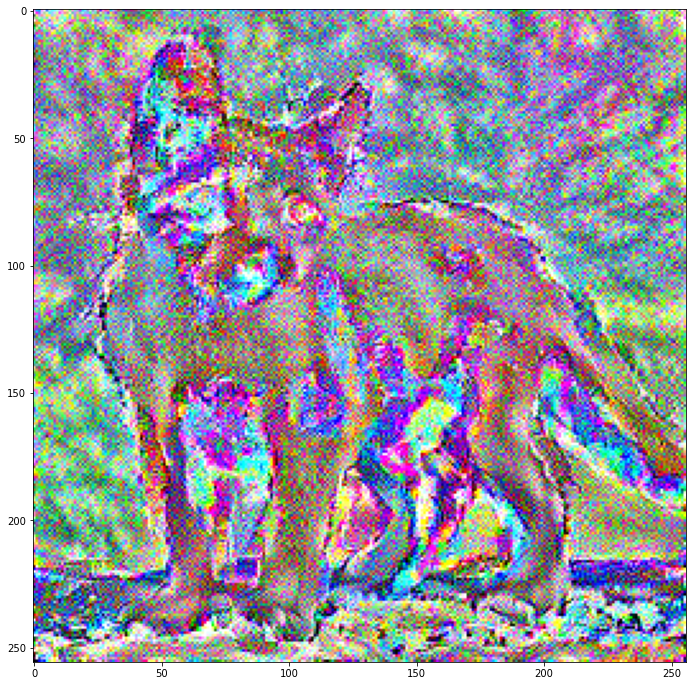

In [65]:
def total_loss(img):
    return 2*content_loss(img)+style_loss(img)

img.assign(img_result)

train(img,loss_fn=total_loss)

The code below performs the actual optimization of loss. Keep in mind that even with GPU the optimization takes significant amount of time. You can run the cell below several times to improve the result.

## Add variation loss

**Variation loss** allows us to make the image less noisy, by minimizing the amount of difference between neighbouring pixels.

We will also start optimization from the original content image, which allows us to keep more content details in the image, without complicating content loss function. We will add some noise, though.

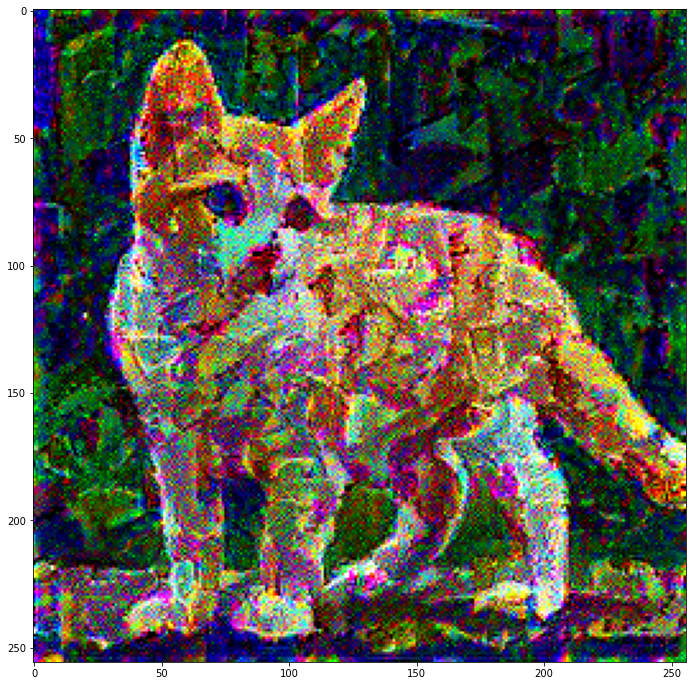

In [95]:
def variation_loss(img):
  img = tf.cast(img,tf.float32)
  x_var = img[ :, 1:, :] - img[ :, :-1, :]
  y_var = img[ 1:, :, :] - img[ :-1, :, :]
  return tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))
  
def total_loss_var(img):
    return content_loss(img)+150*style_loss(img)+30*variation_loss(img)

img.assign(clip(np.random.normal(-0.3,0.3,size=img_content.shape)+img_content/255.0))

train(img,loss_fn=total_loss_var)

In [94]:
cv2.imwrite('result.jpg',(img.numpy()[:,:,::-1]*255))

(256, 256, 3)


True